### 1. Libraries Import

In [1]:
import os, json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.datasets import make_regression
sns.set()
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
import statsmodels.api as sm

### 2. Data Import

In [2]:
datadir = "../data"
outdir = "../output_reports"
outdir_graph = "../figures"
data = os.path.join(datadir, "NSDUH_2023_Tab.txt")

variables_used = [
    # Survey design variables 
    "ANALWT2_C", "VESTR_C", "VEREP",
    # Primary outcomes
    "SUTRTPY", "MHTRTPY",
    # Secondary (telehealth) outcomes
    "TELEAPTYR", "IRSUTPHVID", "IRMHTPHVID",
    # Demographic predictors
    "CATAG6", "IRSEX", "NEWRACE2",
    # Socioeconomic predictors
    "IRMARIT", "IREDUHIGHST2", "IRWRKSTAT18",
    "IRINSUR4", "INCOME",
    # Clinical severity predictors
    "IRPYUD5ALC", "IRPYUD5MRJ", "KSSLR6YR", "IRAMDEYR",
    # Behavioral predictors
    "IRALCFY", "IRMJFY", "ILLYR",
    # Risk perception predictors
    "RSKCIGPKD", "RSKMRJWK"
]

df_og = pd.read_csv(data, sep = "\t", usecols = variables_used, dtype=str)

#export_path = os.path.join(datadir, "NSDUH_2023_subset_raw.csv")
#df_og.to_csv(export_path, index=False)

### 3. Data Cleaning & Remapping

In [3]:
# Simple yes/no in 0/1 form
binary_map_01 = {"0": "No", "1": "Yes"}

# Age (CATAG6)
age_map = {
    "1": "12-17",
    "2": "18-25",
    "3": "26-34",
    "4": "35-49",
    "5": "50-64",
    "6": "65+"
}

# Sex at birth (IRSEX)
sex_map = {"1":"Male","2":"Female"}

race_map = {
    "1": "Non-Hispanic White",
    "2": "Non-Hispanic Black/African American",
    "3": "Non-Hispanic Native American/Alaska Native",
    "4": "Non-Hispanic Native Hawaiian/Other Pacific Islander",
    "5": "Non-Hispanic Asian",
    "6": "Non-Hispanic more than one race",
    "7": "Hispanic"
}

# Family income (INCOME)
income_map = {
    "1":"< $20,000",
    "2":"$20,000-$49,999",
    "3":"$50,000-$74,999",
    "4":"$75,000+"
}

df = df_og.copy()

# Convert survey design variables to numeric
df["ANALWT2_C"] = pd.to_numeric(df["ANALWT2_C"], errors="coerce")
df["VESTR_C"]   = pd.to_numeric(df["VESTR_C"], errors="coerce")
df["VEREP"]     = pd.to_numeric(df["VEREP"], errors="coerce")

df["SUTRTPY_lbl"] = df["SUTRTPY"].map(binary_map_01)
# Convert to numeric for modeling
df["SUTRTPY"] = pd.to_numeric(df["SUTRTPY"], errors="coerce")

df["MHTRTPY_lbl"] = df["MHTRTPY"].map(binary_map_01)
# Convert to numeric for modeling
df["MHTRTPY"] = pd.to_numeric(df["MHTRTPY"], errors="coerce")

# Create a labeled version
df["TELEAPTYR_lbl"] = df["TELEAPTYR"].map({
    "1": "Yes",
    "2": "No",
    "85": "Bad data",
    "94": "Don't know",
    "97": "Refused",
    "98": "Blank"
})

# Convert to numeric (1 = Yes, 0 = No, NaN for all nonresponse codes)
df["TELEAPTYR"] = df["TELEAPTYR"].replace({
    "1": 1,
    "2": 0,
    "85": np.nan,
    "94": np.nan,
    "97": np.nan,
    "98": np.nan
}).astype("float")

df["IRSUTPHVID_lbl"] = df["IRSUTPHVID"].map(binary_map_01)
df["IRSUTPHVID"] = pd.to_numeric(df["IRSUTPHVID"], errors="coerce")

df["IRMHTPHVID_lbl"] = df["IRMHTPHVID"].map(binary_map_01)
df["IRMHTPHVID"] = pd.to_numeric(df["IRMHTPHVID"], errors="coerce")

df["CATAG6_lbl"] = df["CATAG6"].map(age_map)
df["CATAG6"] = pd.to_numeric(df["CATAG6"], errors="coerce")

df["IRSEX_lbl"] = df["IRSEX"].map(sex_map)
df["IRSEX"] = pd.to_numeric(df["IRSEX"], errors="coerce")

df["NEWRACE2_lbl"] = df["NEWRACE2"].map(race_map)
df["NEWRACE2"] = pd.to_numeric(df["NEWRACE2"], errors="coerce")

# Create a labeled version
df["IRMARIT_lbl"] = df["IRMARIT"].map({
    "1": "Married",
    "2": "Widowed",
    "3": "Divorced or Separated",
    "4": "Never Been Married",
    "99": "Legitimate skip (<=14 years old)"
})

# Convert to numeric, set skip to NaN
df["IRMARIT"] = df["IRMARIT"].replace({
    "1": 1,
    "2": 2,
    "3": 3,
    "4": 4,
    "99": np.nan
}).astype("float")

# Create a labeled version
df["IREDUHIGHST2_lbl"] = df["IREDUHIGHST2"].map({
    "1": "Fifth grade or less",
    "2": "Sixth grade",
    "3": "Seventh grade",
    "4": "Eighth grade",
    "5": "Ninth grade",
    "6": "Tenth grade",
    "7": "Eleventh or Twelfth grade, no diploma",
    "8": "High school diploma/GED",
    "9": "Some college credit, no degree",
    "10": "Associate's degree (AA, AS)",
    "11": "College graduate or higher"
})

# Convert to numeric (ordinal: 1–11)
df["IREDUHIGHST2"] = pd.to_numeric(df["IREDUHIGHST2"], errors="coerce")

# Create a labeled version
df["IRWRKSTAT18_lbl"] = df["IRWRKSTAT18"].map({
    "1": "Employed full time",
    "2": "Employed part time",
    "3": "Unemployed",
    "4": "Other (not in labor force)",
    "99": "Legitimate skip (age 12–14)"
})

# Convert to numeric (1–4), recode 99 to NaN
df["IRWRKSTAT18"] = df["IRWRKSTAT18"].replace({
    "1": 1,
    "2": 2,
    "3": 3,
    "4": 4,
    "99": np.nan
}).astype("float")

df["IRINSUR4_lbl"] = df["IRINSUR4"].map({
    "1": "Yes, covered by health insurance",
    "2": "No, not covered by health insurance"
})

# Convert to numeric (1 = Yes, 0 = No)
df["IRINSUR4"] = df["IRINSUR4"].replace({
    "1": 1,
    "2": 0
}).astype("float")

df["INCOME_lbl"] = df["INCOME"].map(income_map)
df["INCOME"] = pd.to_numeric(df["INCOME"], errors="coerce")

# Convert to numeric (1–3), set '.' (college dorm) to NaN

df["IRPYUD5ALC_lbl"] = df["IRPYUD5ALC"].map(binary_map_01)
df["IRPYUD5ALC"] = pd.to_numeric(df["IRPYUD5ALC"], errors="coerce")

df["IRPYUD5MRJ_lbl"] = df["IRPYUD5MRJ"].map(binary_map_01)
df["IRPYUD5MRJ"] = pd.to_numeric(df["IRPYUD5MRJ"], errors="coerce")

df["KSSLR6YR"] = pd.to_numeric(df["KSSLR6YR"], errors="coerce")
# Ensure values outside 0–24 are treated as missing (paranoid safety)
df.loc[~df["KSSLR6YR"].between(0, 24, inclusive="both"), "KSSLR6YR"] = np.nan

df["IRAMDEYR_lbl"] = df["IRAMDEYR"].map({
    "0": "No",
    "1": "Yes",
    ".": "Not applicable (aged 12–17)"
})

# Convert to numeric (1 = Yes, 0 = No, NaN = not applicable)
df["IRAMDEYR"] = df["IRAMDEYR"].replace({
    "0": 0,
    "1": 1,
    ".": np.nan
}).astype("float")

# Create a labeled version
df["IRALCFY_lbl"] = df["IRALCFY"].map({
    "991": "Never used alcohol",
    "993": "No past-year use"
})

# Convert to numeric, treating 991 and 993 as 0 (no use), others keep their day counts
df["IRALCFY"] = df["IRALCFY"].replace({
    "991": 0,
    "993": 0
})
df["IRALCFY"] = pd.to_numeric(df["IRALCFY"], errors="coerce")

# Create a labeled version
df["IRMJFY_lbl"] = df["IRMJFY"].map({
    "991": "Never used marijuana",
    "993": "No past-year use"
})

# Convert to numeric, treating 991 and 993 as 0 (no use), others keep their day counts
df["IRMJFY"] = df["IRMJFY"].replace({
    "991": 0,
    "993": 0
})
df["IRMJFY"] = pd.to_numeric(df["IRMJFY"], errors="coerce")

# Create a labeled version
df["ILLYR_lbl"] = df["ILLYR"].map({
    "0": "Did not use in past year",
    "1": "Used in past year"
})

# Convert to numeric (binary: 0/1)
df["ILLYR"] = df["ILLYR"].replace({
    "0": 0,
    "1": 1
}).astype("float")

# Create a labeled version
df["RSKCIGPKD_lbl"] = df["RSKCIGPKD"].map({
    "1": "No risk",
    "2": "Slight risk",
    "3": "Moderate risk",
    "4": "Great risk",
    "85": "Bad data",
    "94": "Don't know",
    "97": "Refused",
    "98": "Blank"
})

# Convert to numeric (ordinal 1–4), set nonresponse codes to NaN
df["RSKCIGPKD"] = df["RSKCIGPKD"].replace({
    "1": 1,
    "2": 2,
    "3": 3,
    "4": 4,
    "85": np.nan,
    "94": np.nan,
    "97": np.nan,
    "98": np.nan
}).astype("float")

# Create a labeled version
df["RSKMRJWK_lbl"] = df["RSKMRJWK"].map({
    "1": "No risk",
    "2": "Slight risk",
    "3": "Moderate risk",
    "4": "Great risk",
    "85": "Bad data",
    "94": "Don't know",
    "97": "Refused",
    "98": "Blank"
})

# Convert to numeric (ordinal 1–4), set nonresponse codes to NaN
df["RSKMRJWK"] = df["RSKMRJWK"].replace({
    "1": 1,
    "2": 2,
    "3": 3,
    "4": 4,
    "85": np.nan,
    "94": np.nan,
    "97": np.nan,
    "98": np.nan
}).astype("float")

C:\Users\Admin\AppData\Local\Temp\ipykernel_30000\2803965217.py:61: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["TELEAPTYR"] = df["TELEAPTYR"].replace({
C:\Users\Admin\AppData\Local\Temp\ipykernel_30000\2803965217.py:95: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["IRMARIT"] = df["IRMARIT"].replace({
C:\Users\Admin\AppData\Local\Temp\ipykernel_30000\2803965217.py:131: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result

### 4. Data Analysis

#### 4.1. LASSO Logistic Regression Model for SUTRTPY

In [12]:
target = "SUTRTPY"
weight = "ANALWT2_C"

# Numeric (continuous count/score) features
numeric_cols = ["IRALCFY", "IRMJFY", "KSSLR6YR"]

# Treat coded fields as categorical (one-hot)
categorical_cols = [
    "CATAG6","IRSEX","NEWRACE2",
    "IRMARIT","IREDUHIGHST2","IRWRKSTAT18",
    "IRINSUR4","INCOME",
    "IRPYUD5ALC","IRPYUD5MRJ","ILLYR",
    "RSKCIGPKD","RSKMRJWK"
]

# Keep rows with target and weight
work = df.loc[df[target].notna() & df[weight].notna()].copy()
work["w_norm"] = work[weight] / work[weight].mean()

X = work[categorical_cols + numeric_cols]
y = work[target].astype(int).to_numpy().ravel()
w = work["w_norm"].astype(float).to_numpy().ravel()

# Train / test split
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, w, test_size=0.25, random_state=123, stratify=y
)

# Preprocess (impute+encode categoricals, impute+scale numerics)
pre = ColumnTransformer(
    transformers=[
        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=True, drop="first"))
        ]), categorical_cols),
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler(with_mean=False))  # keep sparse compatibility
        ]), numeric_cols),
    ],
    remainder="drop",
    sparse_threshold=1.0
)

# LASSO logistic (CV on C), weighted fit
C_grid = np.logspace(-3, 1, 12)

lasso_cv = LogisticRegressionCV(
    Cs=C_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=123),
    penalty="l1",
    solver="saga",
    scoring="roc_auc",
    max_iter=10000,
    n_jobs=-1,
    refit=True
)

pipe = Pipeline([
    ("pre", pre),
    ("clf", lasso_cv)
])

pipe.fit(X_train, y_train, clf__sample_weight=w_train)

# Evaluate
y_prob = pipe.predict_proba(X_test)[:, 1]
y_hat  = (y_prob >= 0.5).astype(int)
auc    = roc_auc_score(y_test, y_prob, sample_weight=w_test)
acc    = accuracy_score(y_test, y_hat, sample_weight=w_test)

print(f"AUC (weighted): {auc:.3f}")
print(f"Accuracy (weighted, thr=0.5): {acc:.3f}")

# Coefficients + selected features (non-zero)
ohe = pipe.named_steps["pre"].named_transformers_["cat"].named_steps["ohe"]
cat_names = list(ohe.get_feature_names_out(categorical_cols))
feature_names = cat_names + numeric_cols

coef = pipe.named_steps["clf"].coef_.ravel()
selected = [(name, float(wt)) for name, wt in zip(feature_names, coef) if wt != 0]

print(f"Selected features (non-zero): {len(selected)}")
for name, wt in sorted(selected, key=lambda x: abs(x[1]), reverse=True)[:40]:
    print(f"{wt:+.4f}  {name}")

# Metrics
y_prob = pipe.predict_proba(X_test)[:, 1]
y_hat  = (y_prob >= 0.5).astype(int)
auc    = roc_auc_score(y_test, y_prob, sample_weight=w_test)
acc    = accuracy_score(y_test, y_hat, sample_weight=w_test)

with open(os.path.join(outdir + "/SUTRTPY/lasso_output/", f"lasso_{target}_metrics.json"), "w") as f:
    json.dump({"AUC_weighted": float(auc),
               "Accuracy_weighted_thr0.5": float(acc)}, f, indent=2)

# Coefficients
ohe = pipe.named_steps["pre"].named_transformers_["cat"].named_steps["ohe"]
cat_names = list(ohe.get_feature_names_out(categorical_cols))
feature_names = cat_names + numeric_cols

coef = pipe.named_steps["clf"].coef_.ravel()
coef_df = pd.DataFrame({"feature": feature_names, "coef": coef})
coef_df = coef_df.loc[coef_df["coef"] != 0].copy()
coef_df["abs_coef"] = coef_df["coef"].abs()
coef_df.sort_values("abs_coef", ascending=False, inplace=True)

coef_df[["feature","coef"]].to_csv(
    os.path.join(outdir + "/SUTRTPY/lasso_output/", f"lasso_{target}_coefficients.csv"), index=False
)

AUC (weighted): 0.760
Accuracy (weighted, thr=0.5): 0.957
Selected features (non-zero): 44
+1.1558  IRPYUD5ALC_1.0
+1.0937  ILLYR_1.0
+0.8003  IRMARIT_2.0
+0.7845  IREDUHIGHST2_5.0
+0.7573  CATAG6_4.0
+0.7110  IREDUHIGHST2_3.0
+0.7109  IRMARIT_3.0
+0.6443  IRPYUD5MRJ_1.0
+0.5380  IRINSUR4_1.0
-0.5200  IREDUHIGHST2_11.0
+0.5076  NEWRACE2_4.0
-0.4676  NEWRACE2_5.0
+0.4637  IREDUHIGHST2_6.0
+0.4636  IRWRKSTAT18_4.0
-0.4506  NEWRACE2_2.0
-0.4439  INCOME_4.0
-0.4362  IREDUHIGHST2_10.0
+0.4256  CATAG6_5.0
+0.4211  IRMARIT_4.0
-0.4200  CATAG6_6.0
+0.4060  IREDUHIGHST2_4.0
+0.3885  IRWRKSTAT18_3.0
+0.3647  CATAG6_3.0
+0.3537  IRWRKSTAT18_2.0
-0.3390  INCOME_3.0
-0.2944  RSKCIGPKD_3.0
-0.2930  NEWRACE2_6.0
-0.2685  INCOME_2.0
-0.2624  RSKMRJWK_4.0
+0.2554  KSSLR6YR
-0.2515  RSKCIGPKD_4.0
-0.2328  NEWRACE2_7.0
-0.2317  CATAG6_2.0
+0.2103  IREDUHIGHST2_2.0
-0.1841  IRALCFY
-0.1748  IRMJFY
+0.1672  IREDUHIGHST2_7.0
+0.1619  NEWRACE2_3.0
-0.1326  IREDUHIGHST2_9.0
-0.0669  RSKMRJWK_2.0


In [13]:
ohe = pipe.named_steps["pre"].named_transformers_["cat"].named_steps["ohe"]
for var, cats, drop in zip(categorical_cols, ohe.categories_, ohe.drop_idx_):
    if drop is not None:
        ref = cats[drop]
    else:
        ref = "None (no category dropped)"
    print(f"{var}: reference = {ref}")

CATAG6: reference = 1.0
IRSEX: reference = 1.0
NEWRACE2: reference = 1.0
IRMARIT: reference = 1.0
IREDUHIGHST2: reference = 1.0
IRWRKSTAT18: reference = 1.0
IRINSUR4: reference = 0.0
INCOME: reference = 1.0
IRPYUD5ALC: reference = 0.0
IRPYUD5MRJ: reference = 0.0
ILLYR: reference = 0.0
RSKCIGPKD: reference = 1.0
RSKMRJWK: reference = 1.0


#### 4.2. Logistic Regression Model for SUTRTPY using variables captured by LASSO

In [22]:
target = "SUTRTPY"
weight = "ANALWT2_C"

# Top 10 LASSO predictors by absolute coefficient
top_lasso_features = [
    "IREDUHIGHST2", "CATAG6", "NEWRACE2", "IRMARIT", "IRWRKSTAT18",
    "IRPYUD5ALC", "ILLYR", "INCOME", "IRPYUD5MRJ", "RSKCIGPKD"
]

selected_features = list(dict.fromkeys(top_lasso_features))  # ensure uniqueness

print("Variables included in final model:")
for v in selected_features:
    print("-", v)

# Prepare data
cols_for_model = [target, weight] + selected_features
work = df.loc[df[target].notna() & df[weight].notna(), cols_for_model].copy()
work[target] = pd.to_numeric(work[target], errors="coerce")
work[weight] = pd.to_numeric(work[weight], errors="coerce")
work = work.dropna(subset=selected_features)
# Identify numeric predictors (continuous)
numeric_cols = ["KSSLR6YR"]
categorical_cols = [c for c in selected_features if c not in numeric_cols]

# Median impute numeric
#for c in numeric_cols:
#    med = pd.to_numeric(work[c], errors="coerce").median()
#    work[c] = pd.to_numeric(work[c], errors="coerce").fillna(med)

# Dummy encoding and cleanup
X_parts = []
for c in categorical_cols:
    # replace NaN with a literal "Missing" category
    work[c] = work[c].astype("category")
    dummies = pd.get_dummies(work[c], prefix=c, drop_first=True)
    X_parts.append(dummies)

X_cat = pd.concat(X_parts, axis=1)
#X_num = work[numeric_cols]
X = pd.concat([X_cat], axis=1)

# Coerce to numeric and clean
X = X.apply(pd.to_numeric, errors="coerce").replace([np.inf, -np.inf], np.nan)
y = pd.to_numeric(work[target], errors="coerce")
w = pd.to_numeric(work[weight], errors="coerce")

keep = X.notna().all(axis=1) & y.notna() & w.notna()
X = X.loc[keep]
y = y.loc[keep]
w = w.loc[keep]

# Drop constant or duplicate columns
X = X.loc[:, X.nunique(dropna=False) > 1]
X = X.loc[:, ~X.T.duplicated()]

# Add intercept
X = sm.add_constant(X).astype(float)
y = y.astype(float)
w = w.astype(float)

print(f"\nModel fitting on {len(X):,} observations, {X.shape[1]} predictors.")

# weighted logistic regression (robust SEs)
N = len(w)
w_freq = w * (N / w.sum())   # scale such that sum(w_freq) == N

print("sum(freq_weights) =", w_freq.sum())  # sanity: should equal N
print("rank(X) vs cols:", np.linalg.matrix_rank(X.values), X.shape[1])

model = sm.GLM(y, X, family=sm.families.Binomial(), freq_weights=w_freq).fit(cov_type="HC1")
print(model.summary())

# Compute Odds Ratios with 95% CI
ci = model.conf_int()
ci.columns = ["2.5%", "97.5%"]
or_table = pd.DataFrame({
    "OR": np.exp(model.params),
    "2.5%": np.exp(ci["2.5%"]),
    "97.5%": np.exp(ci["97.5%"]),
    "p-value": model.pvalues
}).sort_values("OR", ascending=False)

print("\nTop predictors by OR:")
print(or_table.head(15))

print("\nLowest predictors by OR:")
print(or_table.tail(15))

# Save text summary
with open(os.path.join(outdir + "/SUTRTPY/glm_output/", f"glm_{target}_summary.txt"), "w") as f:
    f.write(model.summary().as_text())

# Save full OR table
or_table.to_csv(os.path.join(outdir + "/SUTRTPY/glm_output/", f"glm_{target}_or_table.csv"))

# Save compact (manuscript-ready) table
nice = or_table.copy()
nice["OR (95% CI)"] = nice.apply(lambda r: f'{r["OR"]:.2f} ({r["2.5%"]:.2f}, {r["97.5%"]:.2f})', axis=1)
nice = nice[["OR (95% CI)", "p-value"]]
nice.to_csv(os.path.join(outdir + "/SUTRTPY/glm_output/", f"glm_{target}_or_table_compact.csv"))

Variables included in final model:
- IREDUHIGHST2
- CATAG6
- NEWRACE2
- IRMARIT
- IRWRKSTAT18
- IRPYUD5ALC
- ILLYR
- INCOME
- IRPYUD5MRJ
- RSKCIGPKD

Model fitting on 44,596 observations, 36 predictors.
sum(freq_weights) = 44596.00000000001
rank(X) vs cols: 36 36
                 Generalized Linear Model Regression Results                  
Dep. Variable:                SUTRTPY   No. Observations:                44596
Model:                            GLM   Df Residuals:                 44560.00
Model Family:                Binomial   Df Model:                           35
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -7027.8
Date:                Sun, 02 Nov 2025   Deviance:                       14056.
Time:                        21:26:59   Pearson chi2:                 4.45e+04
No. Iterations:                     7   Pseudo R-squ. (CS):            0.04793
Covariance Type:         

In [19]:
# weighted counts by category to spot sparse/separated cells
for c in categorical_cols:
    print(c)
    print(work.groupby(c, dropna=False)[weight].sum().sort_values())

# outcome by category (weighted)
for c in categorical_cols:
    print(c)
    print(pd.crosstab(work[c], work[target], values=work[weight], aggfunc='sum', normalize='index'))

# simple separation scan: any category with ~0 or ~1 outcome rate
for c in categorical_cols:
    tab = pd.crosstab(work[c], work[target], values=work[weight], aggfunc='sum').fillna(0)
    rates = tab.get(1, 0) / tab.sum(axis=1)
    print(c, (rates<0.005).sum(), (rates>0.995).sum(), "near-0 or near-1 rates")


IREDUHIGHST2
IREDUHIGHST2
Missing    0.000000e+00
1          3.627547e+06
3          4.940949e+06
2          5.453028e+06
4          6.683883e+06
5          8.128554e+06
6          8.133702e+06
7          1.337730e+07
10         2.494362e+07
9          5.207325e+07
8          6.948772e+07
11         8.660797e+07
Name: ANALWT2_C, dtype: float64
CATAG6
CATAG6
Missing    0.000000e+00
1          2.591519e+07
2          3.403315e+07
3          4.025410e+07
6          5.747057e+07
5          6.161297e+07
4          6.417155e+07
Name: ANALWT2_C, dtype: float64
NEWRACE2
NEWRACE2
Missing    0.000000e+00
4          1.161978e+06
3          1.364070e+06
6          6.149561e+06
5          1.745588e+07
2          3.475589e+07
7          5.224220e+07
1          1.703279e+08
Name: ANALWT2_C, dtype: float64
IRMARIT
IRMARIT
Missing    1.243640e+07
2.0        1.562548e+07
3.0        3.685245e+07
4.0        9.410504e+07
1.0        1.244382e+08
Name: ANALWT2_C, dtype: float64
IRWRKSTAT18
IRWRKSTAT18
3.0   

C:\Users\Admin\AppData\Local\Temp\ipykernel_44448\135009280.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(work.groupby(c, dropna=False)[weight].sum().sort_values())


In [18]:
ref_inferred = {}
for c in categorical_cols:
    cats = list(work[c].cat.categories)
    kept = [col.split(f"{c}_", 1)[1] for col in X_cat.columns if col.startswith(f"{c}_")]
    # the missing one is the dropped reference
    ref = [cat for cat in cats if str(cat) not in kept][0]
    ref_inferred[c] = ref
print("Reference levels (inferred from dummy columns):")
for k, v in ref_inferred.items():
    print(f"- {k}: {v}")

Reference levels (inferred from dummy columns):
- IREDUHIGHST2: 1
- CATAG6: 1
- NEWRACE2: 1
- IRMARIT: 1.0
- IRWRKSTAT18: 1.0
- IRPYUD5ALC: 0
- ILLYR: 0.0
- INCOME: 1
- IRPYUD5MRJ: 0
- RSKCIGPKD: 1.0


#### 4.3. Random Forest Model for SUTRTPY

In [23]:
target = "SUTRTPY"   
weight = "ANALWT2_C"

numeric_cols = ["IRALCFY", "IRMJFY", "KSSLR6YR"]

categorical_cols = [
    "CATAG6","IRSEX","NEWRACE2",
    "IRMARIT","IREDUHIGHST2","IRWRKSTAT18",
    "IRINSUR4","INCOME",
    "IRPYUD5ALC","IRPYUD5MRJ","ILLYR",
    "RSKCIGPKD","RSKMRJWK"
]

work = df.loc[df[target].notna() & df[weight].notna()].copy()
work["w_norm"] = work[weight] / work[weight].mean()

X = work[categorical_cols + numeric_cols]
y = work[target].astype(int).to_numpy().ravel()
w = work["w_norm"].astype(float).to_numpy().ravel()

# Train-test split
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, w, test_size=0.25, random_state=123, stratify=y
)

# Preprocessing
pre = ColumnTransformer(
    transformers=[
        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
        ]), categorical_cols),
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), numeric_cols),
    ],
    remainder="drop"
)

# Random Forest
rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=123,
    n_jobs=-1,
    class_weight=None  
)

pipe_rf = Pipeline([
    ("pre", pre),
    ("clf", rf)
])

pipe_rf.fit(X_train, y_train, clf__sample_weight=w_train)

# Evaluate
y_prob = pipe_rf.predict_proba(X_test)[:, 1]
y_hat  = (y_prob >= 0.5).astype(int)

auc = roc_auc_score(y_test, y_prob, sample_weight=w_test)
acc = accuracy_score(y_test, y_hat, sample_weight=w_test)

print(f"\nRandom Forest results for {target}:")
print(f"AUC (weighted): {auc:.3f}")
print(f"Accuracy (weighted, thr=0.5): {acc:.3f}")

metrics = {
    "target": target,
    "AUC_weighted": float(auc),
    "Accuracy_weighted_thr0.5": float(acc),
    "N_train": len(y_train),
    "N_test": len(y_test)
}

# Save metrics JSON
with open(os.path.join(outdir + "/SUTRTPY/rf_output/", f"rf_{target}_metrics.json"), "w") as f:
    json.dump(metrics, f, indent=2)

# Feature Importance
# Get feature names after preprocessing
cat_names = pipe_rf.named_steps["pre"].named_transformers_["cat"].named_steps["ohe"].get_feature_names_out(categorical_cols)
feature_names = list(cat_names) + numeric_cols

importances = pipe_rf.named_steps["clf"].feature_importances_
imp_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
imp_df = imp_df.sort_values("Importance", ascending=False)

imp_df.to_csv(os.path.join(outdir + "/SUTRTPY/rf_output/", f"rf_{target}_feature_importance.csv"), index=False)


Random Forest results for SUTRTPY:
AUC (weighted): 0.783
Accuracy (weighted, thr=0.5): 0.957


In [10]:
def run_elastic_net_selection(
    df,
    TARGET,
    WEIGHT="ANALWT2_C",
    categorical_cols=None,
    numeric_cols=None,
    outdir="../output_reports",
    model_name="elasticnet",
    Cs=np.logspace(-3, 1, 10),         # inverse regularization strengths
    l1_grid=np.linspace(0.1, 0.9, 9),  # proportion L1 (0<l1_ratio<1)
    random_state=123
):
    """
    Elastic Net logistic regression with CV-tuned C & l1_ratio.
    Exports:
      - <outdir>/<TARGET>/<model_name>_output/<model_name>_<TARGET>_coefficients.csv
      - <outdir>/<TARGET>/<model_name>_output/<model_name>_<TARGET>_metrics.csv
    Returns (best_estimator, coef_df, metrics_dict)
    """
    assert TARGET in df.columns, f"{TARGET} not in df"
    assert WEIGHT in df.columns, f"{WEIGHT} not in df"

    # Defaults
    categorical_cols = categorical_cols or []
    numeric_cols = numeric_cols or []

    # Keep rows with target & weight
    work = df.loc[df[TARGET].notna() & df[WEIGHT].notna()].copy()
    # Normalize weights to mean 1 for stability in CV
    work["_w"] = pd.to_numeric(work[WEIGHT], errors="coerce")
    work["_w"] = work["_w"] / work["_w"].mean()

    # X/y/w
    X = work[categorical_cols + numeric_cols].copy()
    y = pd.to_numeric(work[TARGET], errors="coerce").astype(int).to_numpy().ravel()
    w = work["_w"].astype(float).to_numpy().ravel()

    # Train/test split (stratified)
    X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
        X, y, w, test_size=0.25, random_state=random_state, stratify=y
    )

    # Preprocess
    pre = ColumnTransformer(
        transformers=[
            ("cat", Pipeline(steps=[
                ("imputer", SimpleImputer(strategy="most_frequent")),
                # drop='if_binary' keeps single dummy for 2-level vars; still safe for GLM later
                ("ohe", OneHotEncoder(handle_unknown="ignore",
                                      sparse_output=True, drop="first"))
            ]), categorical_cols),
            ("num", Pipeline(steps=[
                ("imputer", SimpleImputer(strategy="median")),
                # keep sparse compatibility
                ("scaler", StandardScaler(with_mean=False))
            ]), numeric_cols),
        ],
        remainder="drop",
        sparse_threshold=1.0
    )

    # Base classifier (Elastic Net logistic)
    base_clf = LogisticRegression(
        penalty="elasticnet",
        solver="saga",
        max_iter=10000,
        fit_intercept=True,
        n_jobs=-1,
        random_state=random_state
    )

    # Grid over C and l1_ratio
    param_grid = {
        "clf__C": Cs,
        "clf__l1_ratio": l1_grid
    }

    pipe = Pipeline([
        ("pre", pre),
        ("clf", base_clf),
    ])

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

    gs = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring="roc_auc",
        cv=cv,
        n_jobs=-1,
        refit=True,
        verbose=0
    )

    # Fit with sample weights
    gs.fit(X_train, y_train, clf__sample_weight=w_train)

    best_pipe = gs.best_estimator_
    best_params = gs.best_params_

    # Evaluate (weighted)
    y_prob = best_pipe.predict_proba(X_test)[:, 1]
    y_hat = (y_prob >= 0.5).astype(int)
    auc = roc_auc_score(y_test, y_prob, sample_weight=w_test)
    acc = accuracy_score(y_test, y_hat, sample_weight=w_test)

    # --- Build nice feature-name list ---
    # OneHot categories
    ohe = best_pipe.named_steps["pre"].named_transformers_["cat"].named_steps["ohe"]
    cat_names = list(ohe.get_feature_names_out(categorical_cols))
    feature_names = cat_names + numeric_cols

    # Coefficients
    coef = best_pipe.named_steps["clf"].coef_.ravel()

    # Keep non-zero-ish (Elastic Net can produce tiny but non-zero coefs)
    nz_mask = np.abs(coef) > 1e-6
    selected = [(name, float(wt)) for name, wt in zip(feature_names, coef) if abs(wt) > 1e-6]

    coef_df = pd.DataFrame(selected, columns=["feature", "coef"])
    coef_df["abs_coef"] = coef_df["coef"].abs()
    coef_df = coef_df.sort_values("abs_coef", ascending=False, ignore_index=True)

    # Export
    outdir_model = os.path.join(outdir, TARGET, f"{model_name}_output")
    os.makedirs(outdir_model, exist_ok=True)

    coef_path = os.path.join(outdir_model, f"{model_name}_{TARGET}_coefficients.csv")
    metrics_path = os.path.join(outdir_model, f"{model_name}_{TARGET}_metrics.csv")

    coef_df.to_csv(coef_path, index=False)

    metrics = {
        "target": TARGET,
        "n_train": int(len(y_train)),
        "n_test": int(len(y_test)),
        "auc_weighted": float(auc),
        "acc_weighted_thr_0.5": float(acc),
        "best_C": float(best_params["clf__C"]),
        "best_l1_ratio": float(best_params["clf__l1_ratio"]),
        "n_selected_features": int(nz_mask.sum())
    }
    pd.DataFrame([metrics]).to_csv(metrics_path, index=False)

    print(f"[{TARGET}] Elastic Net — AUC: {auc:.3f}, Acc: {acc:.3f}, "
          f"best C={metrics['best_C']:.4g}, l1_ratio={metrics['best_l1_ratio']:.2f}, "
          f"selected={metrics['n_selected_features']}")

    return best_pipe, coef_df, metrics

In [11]:
categorical_cols = [
    "CATAG6","IRSEX","NEWRACE2",
    "IRMARIT","IREDUHIGHST2","IRWRKSTAT18",
    "IRINSUR4","INCOME",
    "IRPYUD5ALC","IRPYUD5MRJ","ILLYR",
    "RSKCIGPKD","RSKMRJWK"
]
numeric_cols = ["IRALCFY", "IRMJFY", "KSSLR6YR"]                   # numeric/continuous only
categorical_SUTRTPY = [c for c in categorical_cols if c not in numeric_cols]

# Run Elastic Net for SUTRTPY
_ = run_elastic_net_selection(
    df=df,
    TARGET="SUTRTPY",
    WEIGHT="ANALWT2_C",
    categorical_cols=categorical_SUTRTPY,
    numeric_cols=numeric_cols,
    outdir="../output_reports",
    model_name="elasticnet"
)

KeyboardInterrupt: 

#### 4.4. LASSO Logistic Regression Model for MHTRTPY

In [25]:
target = "MHTRTPY"
weight = "ANALWT2_C"

# Numeric (continuous count/score) features
numeric_cols = ["IRALCFY", "IRMJFY", "KSSLR6YR"]

# Treat coded fields as categorical (one-hot)
categorical_cols = [
    "CATAG6","IRSEX","NEWRACE2",
    "IRMARIT","IREDUHIGHST2","IRWRKSTAT18",
    "IRINSUR4","INCOME",
    "IRPYUD5ALC","IRPYUD5MRJ","ILLYR",
    "RSKCIGPKD","RSKMRJWK"
]

# Keep rows with target and weight
work = df.loc[df[target].notna() & df[weight].notna()].copy()
work["w_norm"] = work[weight] / work[weight].mean()

X = work[categorical_cols + numeric_cols]
y = work[target].astype(int).to_numpy().ravel()
w = work["w_norm"].astype(float).to_numpy().ravel()

# Train / test split
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, w, test_size=0.25, random_state=123, stratify=y
)

# Preprocess (impute+encode categoricals, impute+scale numerics)
pre = ColumnTransformer(
    transformers=[
        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=True, drop="first"))
        ]), categorical_cols),
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler(with_mean=False))  # keep sparse compatibility
        ]), numeric_cols),
    ],
    remainder="drop",
    sparse_threshold=1.0
)

# LASSO logistic (CV on C), weighted fit
C_grid = np.logspace(-3, 1, 12)

lasso_cv = LogisticRegressionCV(
    Cs=C_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=123),
    penalty="l1",
    solver="saga",
    scoring="roc_auc",
    max_iter=10000,
    n_jobs=-1,
    refit=True
)

pipe = Pipeline([
    ("pre", pre),
    ("clf", lasso_cv)
])

pipe.fit(X_train, y_train, clf__sample_weight=w_train)

# Evaluate
y_prob = pipe.predict_proba(X_test)[:, 1]
y_hat  = (y_prob >= 0.5).astype(int)
auc    = roc_auc_score(y_test, y_prob, sample_weight=w_test)
acc    = accuracy_score(y_test, y_hat, sample_weight=w_test)

print(f"AUC (weighted): {auc:.3f}")
print(f"Accuracy (weighted, thr=0.5): {acc:.3f}")

# Coefficients + selected features (non-zero)
ohe = pipe.named_steps["pre"].named_transformers_["cat"].named_steps["ohe"]
cat_names = list(ohe.get_feature_names_out(categorical_cols))
feature_names = cat_names + numeric_cols

coef = pipe.named_steps["clf"].coef_.ravel()
selected = [(name, float(wt)) for name, wt in zip(feature_names, coef) if wt != 0]

print(f"Selected features (non-zero): {len(selected)}")
for name, wt in sorted(selected, key=lambda x: abs(x[1]), reverse=True)[:40]:
    print(f"{wt:+.4f}  {name}")

# Metrics
y_prob = pipe.predict_proba(X_test)[:, 1]
y_hat  = (y_prob >= 0.5).astype(int)
auc    = roc_auc_score(y_test, y_prob, sample_weight=w_test)
acc    = accuracy_score(y_test, y_hat, sample_weight=w_test)

with open(os.path.join(outdir + "/MHTRTPY/lasso_output/", f"lasso_{target}_metrics.json"), "w") as f:
    json.dump({"AUC_weighted": float(auc),
               "Accuracy_weighted_thr0.5": float(acc)}, f, indent=2)

# Coefficients 
ohe = pipe.named_steps["pre"].named_transformers_["cat"].named_steps["ohe"]
cat_names = list(ohe.get_feature_names_out(categorical_cols))
feature_names = cat_names + numeric_cols

coef = pipe.named_steps["clf"].coef_.ravel()
coef_df = pd.DataFrame({"feature": feature_names, "coef": coef})
coef_df = coef_df.loc[coef_df["coef"] != 0].copy()
coef_df["abs_coef"] = coef_df["coef"].abs()
coef_df.sort_values("abs_coef", ascending=False, inplace=True)

coef_df[["feature","coef"]].to_csv(
    os.path.join(outdir + "/MHTRTPY/lasso_output/", f"lasso_{target}_coefficients.csv"), index=False
)


AUC (weighted): 0.701
Accuracy (weighted, thr=0.5): 0.775
Selected features (non-zero): 43
-1.2436  CATAG6_6.0
-0.8799  CATAG6_5.0
-0.8355  NEWRACE2_2.0
-0.8152  CATAG6_2.0
-0.8073  NEWRACE2_5.0
+0.7344  IRSEX_2.0
-0.6491  NEWRACE2_4.0
-0.6387  CATAG6_3.0
-0.6361  CATAG6_4.0
+0.5701  IRINSUR4_1.0
+0.5683  ILLYR_1.0
-0.5629  RSKMRJWK_4.0
-0.5451  NEWRACE2_7.0
+0.4205  IRPYUD5ALC_1.0
+0.4186  RSKCIGPKD_4.0
+0.4160  RSKCIGPKD_3.0
+0.3692  IREDUHIGHST2_11.0
+0.3336  IRMARIT_3.0
-0.3254  IREDUHIGHST2_7.0
+0.3163  IRPYUD5MRJ_1.0
-0.2859  NEWRACE2_3.0
+0.2710  IRWRKSTAT18_4.0
+0.2621  IRWRKSTAT18_2.0
-0.2473  IREDUHIGHST2_8.0
+0.2405  RSKCIGPKD_2.0
+0.2015  KSSLR6YR
+0.1784  IRMARIT_4.0
-0.1680  RSKMRJWK_3.0
+0.1403  IREDUHIGHST2_9.0
+0.1330  IRWRKSTAT18_3.0
-0.1234  IRALCFY
-0.1076  IREDUHIGHST2_6.0
-0.0967  IREDUHIGHST2_4.0
+0.0889  IREDUHIGHST2_2.0
+0.0797  IREDUHIGHST2_10.0
+0.0689  INCOME_3.0
-0.0668  INCOME_4.0
-0.0656  NEWRACE2_6.0
+0.0404  RSKMRJWK_2.0
-0.0295  IREDUHIGHST2_3.0


#### 4.5. Logistic Regression Model for MHTRTPY using variables captured by LASSO

In [27]:
target = "MHTRTPY"
weight = "ANALWT2_C"

# Top 10 LASSO predictors
top_lasso_features = [
    "CATAG6", "NEWRACE2", "IREDUHIGHST2", "RSKCIGPKD", "RSKMRJWK",
    "IRSEX", "IRWRKSTAT18", "IRINSUR4", "ILLYR", "IRMARIT"
]

selected_features = list(dict.fromkeys(top_lasso_features))

print("Variables included in MHTRTPY model:")
for v in selected_features:
    print("-", v)

# Prepare data
cols_for_model = [target, weight] + selected_features
work = df.loc[df[target].notna() & df[weight].notna(), cols_for_model].copy()
work[target] = pd.to_numeric(work[target], errors="coerce")
work[weight] = pd.to_numeric(work[weight], errors="coerce")
work = work.dropna(subset=selected_features)

# Numeric vs categorical
numeric_cols = ["KSSLR6YR"]
categorical_cols = [c for c in selected_features if c not in numeric_cols]

# Median impute numeric
#for c in numeric_cols:
#    med = pd.to_numeric(work[c], errors="coerce").median()
#    work[c] = pd.to_numeric(work[c], errors="coerce").fillna(med)

# Dummy encoding (explicit Missing category)
X_parts = []
for c in categorical_cols:
    work[c] = work[c].astype("category")
    dummies = pd.get_dummies(work[c], prefix=c, drop_first=True)
    X_parts.append(dummies)

X_cat = pd.concat(X_parts, axis=1)
#X_num = work[numeric_cols]
X = pd.concat([X_cat], axis=1)

# Clean dtypes
X = X.apply(pd.to_numeric, errors="coerce").replace([np.inf, -np.inf], np.nan)
y = pd.to_numeric(work[target], errors="coerce")
w = pd.to_numeric(work[weight], errors="coerce")

keep = X.notna().all(axis=1) & y.notna() & w.notna()
X = X.loc[keep]
y = y.loc[keep]
w = w.loc[keep]

# Drop constants/duplicates
X = X.loc[:, X.nunique(dropna=False) > 1]
X = X.loc[:, ~X.T.duplicated()]

# Add constant
X = sm.add_constant(X).astype(float)
y = y.astype(float)
w = w.astype(float)

# Fit weighted logistic regression (robust SEs)
N = len(w)
w_freq = w * (N / w.sum())   # scaled so sum(weights) == N

print(f"\nModel fitting on {N:,} observations, {X.shape[1]} predictors.")
print("sum(freq_weights) =", w_freq.sum())
print("rank(X) vs cols:", np.linalg.matrix_rank(X.values), X.shape[1])

model = sm.GLM(y, X, family=sm.families.Binomial(), freq_weights=w_freq).fit(cov_type="HC1")
print(model.summary())

# Compute Odds Ratios with 95% CI
ci = model.conf_int()
ci.columns = ["2.5%", "97.5%"]
or_table = pd.DataFrame({
    "OR": np.exp(model.params),
    "2.5%": np.exp(ci["2.5%"]),
    "97.5%": np.exp(ci["97.5%"]),
    "p-value": model.pvalues
}).sort_values("OR", ascending=False)

print("\nTop predictors by OR:")
print(or_table.head(15))
print("\nLowest predictors by OR:")
print(or_table.tail(15))

# Save text summary 
with open(os.path.join(outdir + "/MHTRTPY/glm_output/", f"glm_{target}_summary.txt"), "w") as f:
    f.write(model.summary().as_text())

# Save full OR table
or_table.to_csv(os.path.join(outdir + "/MHTRTPY/glm_output/", f"glm_{target}_or_table.csv"))

# Save compact (manuscript-ready) table
nice = or_table.copy()
nice["OR (95% CI)"] = nice.apply(lambda r: f'{r["OR"]:.2f} ({r["2.5%"]:.2f}, {r["97.5%"]:.2f})', axis=1)
nice = nice[["OR (95% CI)", "p-value"]]
nice.to_csv(os.path.join(outdir + "/MHTRTPY/glm_output/", f"glm_{target}_or_table_compact.csv"))

Variables included in MHTRTPY model:
- CATAG6
- NEWRACE2
- IREDUHIGHST2
- RSKCIGPKD
- RSKMRJWK
- IRSEX
- IRWRKSTAT18
- IRINSUR4
- ILLYR
- IRMARIT

Model fitting on 44,365 observations, 36 predictors.
sum(freq_weights) = 44365.0
rank(X) vs cols: 36 36
                 Generalized Linear Model Regression Results                  
Dep. Variable:                MHTRTPY   No. Observations:                44365
Model:                            GLM   Df Residuals:                    44329
Model Family:                Binomial   Df Model:                           35
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -21829.
Date:                Sun, 02 Nov 2025   Deviance:                       43658.
Time:                        21:34:20   Pearson chi2:                 4.50e+04
No. Iterations:                     5   Pseudo R-squ. (CS):            0.09566
Covariance Type:                  HC1 

In [28]:
ref_inferred = {}
for c in categorical_cols:
    cats = list(work[c].cat.categories)
    kept = [col.split(f"{c}_", 1)[1] for col in X_cat.columns if col.startswith(f"{c}_")]
    # the missing one is the dropped reference
    ref = [cat for cat in cats if str(cat) not in kept][0]
    ref_inferred[c] = ref
print("Reference levels (inferred from dummy columns):")
for k, v in ref_inferred.items():
    print(f"- {k}: {v}")

Reference levels (inferred from dummy columns):
- CATAG6: 2
- NEWRACE2: 1
- IREDUHIGHST2: 1
- RSKCIGPKD: 1.0
- RSKMRJWK: 1.0
- IRSEX: 1
- IRWRKSTAT18: 1.0
- IRINSUR4: 0.0
- ILLYR: 0.0
- IRMARIT: 1.0


#### 4.6. Random Forest Model for MHTRTPY   

In [30]:
target = "MHTRTPY"   
weight = "ANALWT2_C"

numeric_cols = ["IRALCFY", "IRMJFY", "KSSLR6YR"]

categorical_cols = [
    "CATAG6","IRSEX","NEWRACE2",
    "IRMARIT","IREDUHIGHST2","IRWRKSTAT18",
    "IRINSUR4","INCOME",
    "IRPYUD5ALC","IRPYUD5MRJ","ILLYR",
    "RSKCIGPKD","RSKMRJWK"
]

work = df.loc[df[target].notna() & df[weight].notna()].copy()
work["w_norm"] = work[weight] / work[weight].mean()

X = work[categorical_cols + numeric_cols]
y = work[target].astype(int).to_numpy().ravel()
w = work["w_norm"].astype(float).to_numpy().ravel()

# Train-test split
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, w, test_size=0.25, random_state=123, stratify=y
)

# Preprocessing
pre = ColumnTransformer(
    transformers=[
        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
        ]), categorical_cols),
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), numeric_cols),
    ],
    remainder="drop"
)

# Random Forest
rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=123,
    n_jobs=-1,
    class_weight=None  
)

pipe_rf = Pipeline([
    ("pre", pre),
    ("clf", rf)
])

pipe_rf.fit(X_train, y_train, clf__sample_weight=w_train)

# Evaluate
y_prob = pipe_rf.predict_proba(X_test)[:, 1]
y_hat  = (y_prob >= 0.5).astype(int)

auc = roc_auc_score(y_test, y_prob, sample_weight=w_test)
acc = accuracy_score(y_test, y_hat, sample_weight=w_test)

print(f"\nRandom Forest results for {target}:")
print(f"AUC (weighted): {auc:.3f}")
print(f"Accuracy (weighted, thr=0.5): {acc:.3f}")

metrics = {
    "target": target,
    "AUC_weighted": float(auc),
    "Accuracy_weighted_thr0.5": float(acc),
    "N_train": len(y_train),
    "N_test": len(y_test)
}

# Save metrics JSON
with open(os.path.join(outdir + "/MHTRTPY/rf_output/", f"rf_{target}_metrics.json"), "w") as f:
    json.dump(metrics, f, indent=2)

# Feature Importance
# Get feature names after preprocessing
cat_names = pipe_rf.named_steps["pre"].named_transformers_["cat"].named_steps["ohe"].get_feature_names_out(categorical_cols)
feature_names = list(cat_names) + numeric_cols

importances = pipe_rf.named_steps["clf"].feature_importances_
imp_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
imp_df = imp_df.sort_values("Importance", ascending=False)

imp_df.to_csv(os.path.join(outdir + "/MHTRTPY/rf_output/", f"rf_{target}_feature_importance.csv"), index=False)


Random Forest results for MHTRTPY:
AUC (weighted): 0.731
Accuracy (weighted, thr=0.5): 0.786


#### 4.7. LASSO Logistic Regression Model for TELEAPTYR

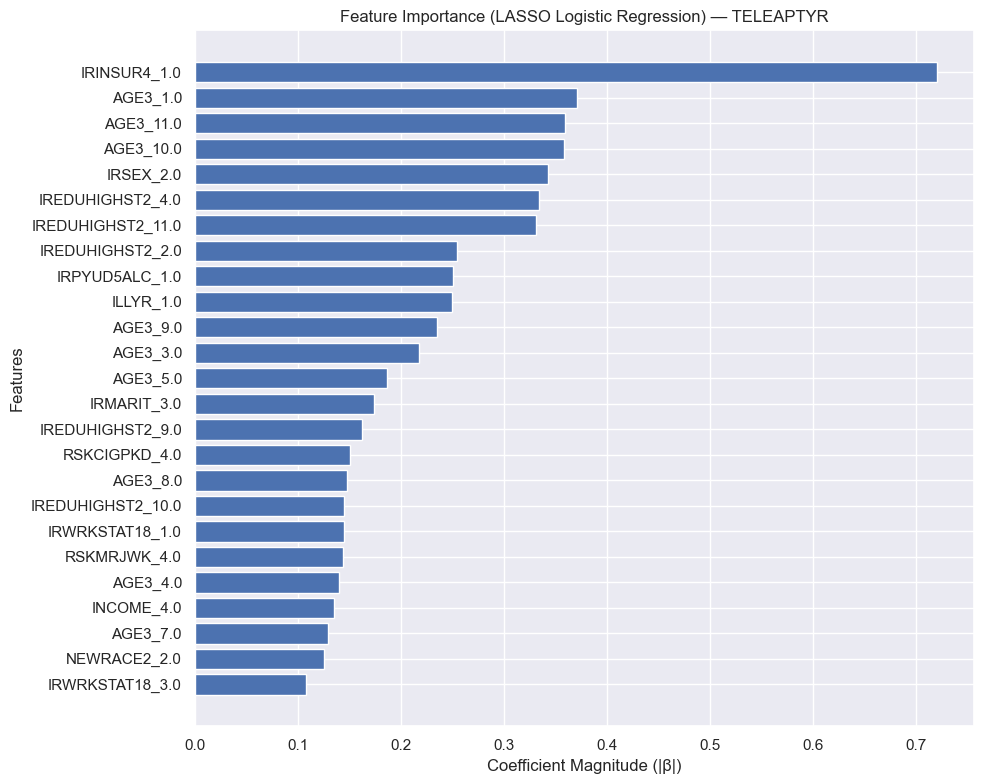

In [94]:
target = "TELEAPTYR" 
coef_path = os.path.join(outdir + "/TELEAPTYR/lasso_output/", f"lasso_{target}_coefficients.csv")
top_n = 25           # number of features to display

coef_df = pd.read_csv(coef_path)

# Clean and prepare
coef_df = coef_df.rename(columns={"feature": "Feature", "coef": "Coefficient"})
coef_df["AbsCoef"] = coef_df["Coefficient"].abs()

# Sort by absolute magnitude (descending)
coef_df = coef_df.sort_values(by="AbsCoef", ascending=False, ignore_index=True)

# Plot
plt.figure(figsize=(10, 8))
plt.barh(coef_df["Feature"].head(top_n), coef_df["AbsCoef"].head(top_n)) 
plt.xlabel("Coefficient Magnitude (|β|)")
plt.ylabel("Features")
plt.title(f"Feature Importance (LASSO Logistic Regression) — {target}")
plt.gca().invert_yaxis()  
plt.tight_layout()

save_path = os.path.join(outdir_graph, f"lasso_{target}_feature_importance_from_export.png")
plt.savefig(save_path, dpi=200)
plt.show()

#### 4.8. Logistic Regression Model for TELEAPTYR using variables captured by LASSO

In [97]:
target = "TELEAPTYR"
weight = "ANALWT2_C"

# Top 10 LASSO predictors
top_lasso_features = [
    "IRSEX", "IRINSUR4", "ILLYR", "IRPYUD5ALC", "IRPYUD5MRJ",
    "KSSLR6YR", "NEWRACE2", "IRMARIT", "IREDUHIGHST2", "IRWRKSTAT18"
]
core_demo = ["INCOME", "POVERTY3"]

selected_features = list(dict.fromkeys(top_lasso_features + core_demo))

print("Variables included in MHTRTPY model:")
for v in selected_features:
    print("-", v)

# Prepare data
work = df.loc[df[target].notna() & df[weight].notna(), [target, weight] + selected_features].copy()
work[target] = pd.to_numeric(work[target], errors="coerce")
work[weight] = pd.to_numeric(work[weight], errors="coerce")

# Numeric vs categorical
numeric_cols = ["KSSLR6YR"]
categorical_cols = [c for c in selected_features if c not in numeric_cols]

# Median impute numeric
for c in numeric_cols:
    med = pd.to_numeric(work[c], errors="coerce").median()
    work[c] = pd.to_numeric(work[c], errors="coerce").fillna(med)

# Dummy encoding (explicit Missing category)
X_parts = []
for c in categorical_cols:
    work[c] = work[c].astype("category").cat.add_categories("Missing").fillna("Missing")
    dummies = pd.get_dummies(work[c], prefix=c, drop_first=True)
    X_parts.append(dummies)

X_cat = pd.concat(X_parts, axis=1)
X_num = work[numeric_cols]
X = pd.concat([X_cat, X_num], axis=1)

# Clean dtypes
X = X.apply(pd.to_numeric, errors="coerce").replace([np.inf, -np.inf], np.nan)
y = pd.to_numeric(work[target], errors="coerce")
w = pd.to_numeric(work[weight], errors="coerce")

keep = X.notna().all(axis=1) & y.notna() & w.notna()
X = X.loc[keep]
y = y.loc[keep]
w = w.loc[keep]

# Drop constants/duplicates
X = X.loc[:, X.nunique(dropna=False) > 1]
X = X.loc[:, ~X.T.duplicated()]

# Add constant
X = sm.add_constant(X).astype(float)
y = y.astype(float)
w = w.astype(float)

# Fit weighted logistic regression (robust SEs)
N = len(w)
w_freq = w * (N / w.sum())   # scaled so sum(weights) == N

print(f"\nModel fitting on {N:,} observations, {X.shape[1]} predictors.")
print("sum(freq_weights) =", w_freq.sum())
print("rank(X) vs cols:", np.linalg.matrix_rank(X.values), X.shape[1])

model = sm.GLM(y, X, family=sm.families.Binomial(), freq_weights=w_freq).fit(cov_type="HC1")
print(model.summary())

# Compute Odds Ratios with 95% CI
ci = model.conf_int()
ci.columns = ["2.5%", "97.5%"]
or_table = pd.DataFrame({
    "OR": np.exp(model.params),
    "2.5%": np.exp(ci["2.5%"]),
    "97.5%": np.exp(ci["97.5%"]),
    "p-value": model.pvalues
}).sort_values("OR", ascending=False)

print("\nTop predictors by OR:")
print(or_table.head(15))
print("\nLowest predictors by OR:")
print(or_table.tail(15))

# Save text summary 
with open(os.path.join(outdir + "/TELEAPTYR/glm_output/", f"glm_{target}_summary.txt"), "w") as f:
    f.write(model.summary().as_text())

# Save full OR table
or_table.to_csv(os.path.join(outdir + "/TELEAPTYR/glm_output/", f"glm_{target}_or_table.csv"))

# Save compact (manuscript-ready) table
nice = or_table.copy()
nice["OR (95% CI)"] = nice.apply(lambda r: f'{r["OR"]:.2f} ({r["2.5%"]:.2f}, {r["97.5%"]:.2f})', axis=1)
nice = nice[["OR (95% CI)", "p-value"]]
nice.to_csv(os.path.join(outdir + "/TELEAPTYR/glm_output/", f"glm_{target}_or_table_compact.csv"))

Variables included in MHTRTPY model:
- IRSEX
- IRINSUR4
- ILLYR
- IRPYUD5ALC
- IRPYUD5MRJ
- KSSLR6YR
- NEWRACE2
- IRMARIT
- IREDUHIGHST2
- IRWRKSTAT18
- INCOME
- POVERTY3

Model fitting on 55,622 observations, 37 predictors.
sum(freq_weights) = 55622.0
rank(X) vs cols: 37 37
                 Generalized Linear Model Regression Results                  
Dep. Variable:              TELEAPTYR   No. Observations:                55622
Model:                            GLM   Df Residuals:                    55585
Model Family:                Binomial   Df Model:                           36
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -31929.
Date:                Sun, 19 Oct 2025   Deviance:                       63859.
Time:                        23:57:48   Pearson chi2:                 5.56e+04
No. Iterations:                     6   Pseudo R-squ. (CS):            0.04208
Covariance Ty

#### 4.9. Random Forest Model for TELEAPTYR 


 Random Forest results for TELEAPTYR:
AUC (weighted): 0.614
Accuracy (weighted, thr=0.5): 0.719


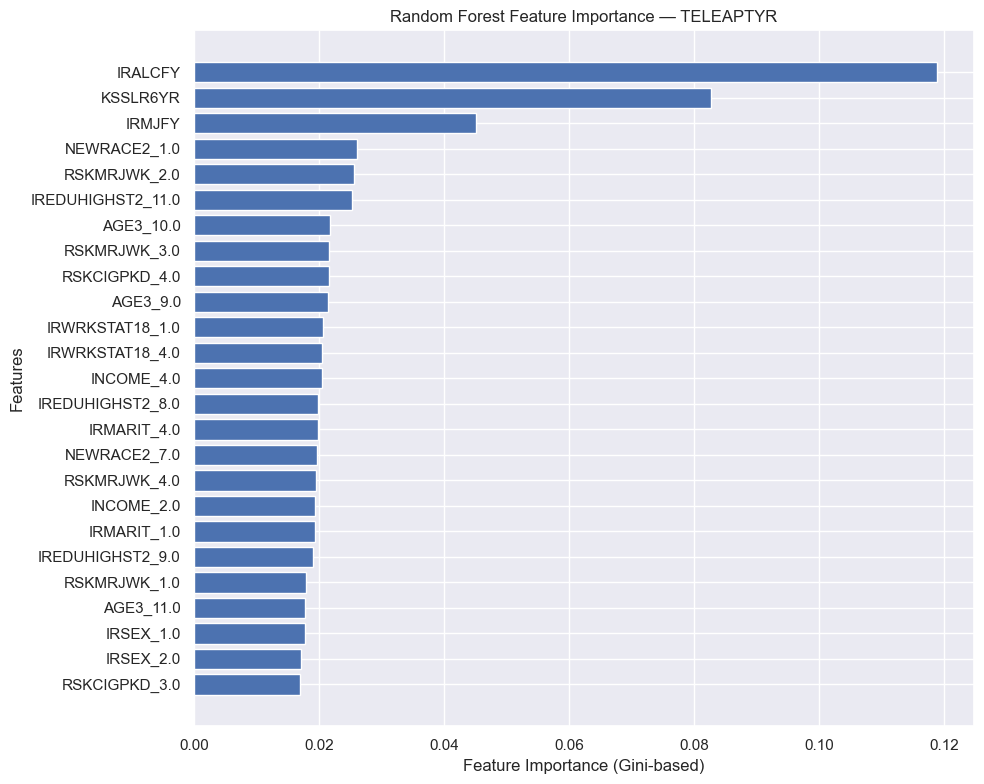

In [ ]:
target = "TELEAPTYR"   
weight = "ANALWT2_C"

numeric_cols = ["IRALCFY", "IRMJFY", "KSSLR6YR"]

categorical_cols = [
    "CATAG6","IRSEX","NEWRACE2",
    "IRMARIT","IREDUHIGHST2","IRWRKSTAT18",
    "IRINSUR4","INCOME","POVERTY3",
    "IRPYUD5ALC","IRPYUD5MRJ","ILLYR",
    "RSKCIGPKD","RSKMRJWK"
]

work = df.loc[df[target].notna() & df[weight].notna()].copy()
work["w_norm"] = work[weight] / work[weight].mean()

X = work[categorical_cols + numeric_cols]
y = work[target].astype(int).to_numpy().ravel()
w = work["w_norm"].astype(float).to_numpy().ravel()

# Train-test split
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, w, test_size=0.25, random_state=123, stratify=y
)

# Preprocessing
pre = ColumnTransformer(
    transformers=[
        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
        ]), categorical_cols),
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), numeric_cols),
    ],
    remainder="drop"
)

# Random Forest
rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=123,
    n_jobs=-1,
    class_weight=None  
)

pipe_rf = Pipeline([
    ("pre", pre),
    ("clf", rf)
])

pipe_rf.fit(X_train, y_train, clf__sample_weight=w_train)

# Evaluate
y_prob = pipe_rf.predict_proba(X_test)[:, 1]
y_hat  = (y_prob >= 0.5).astype(int)

auc = roc_auc_score(y_test, y_prob, sample_weight=w_test)
acc = accuracy_score(y_test, y_hat, sample_weight=w_test)

print(f"\n Random Forest results for {target}:")
print(f"AUC (weighted): {auc:.3f}")
print(f"Accuracy (weighted, thr=0.5): {acc:.3f}")

metrics = {
    "target": target,
    "AUC_weighted": float(auc),
    "Accuracy_weighted_thr0.5": float(acc),
    "N_train": len(y_train),
    "N_test": len(y_test)
}

# Save metrics JSON
with open(os.path.join(outdir + "/TELEAPTYR/rf_output/", f"rf_{target}_metrics.json"), "w") as f:
    json.dump(metrics, f, indent=2)

# Feature Importance
# Get feature names after preprocessing
cat_names = pipe_rf.named_steps["pre"].named_transformers_["cat"].named_steps["ohe"].get_feature_names_out(categorical_cols)
feature_names = list(cat_names) + numeric_cols

importances = pipe_rf.named_steps["clf"].feature_importances_
imp_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
imp_df = imp_df.sort_values("Importance", ascending=False)

imp_df.to_csv(os.path.join(outdir + "/TELEAPTYR/rf_output/", f"rf_{target}_feature_importance.csv"), index=False)

# Plot & Export
top_n = 25
plt.figure(figsize=(10, 8))
plt.barh(imp_df["Feature"].head(top_n), imp_df["Importance"].head(top_n))
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance (Gini-based)")
plt.ylabel("Features")
plt.title(f"Random Forest Feature Importance — {target}")
plt.tight_layout()

plt.savefig(os.path.join(outdir_graph, f"rf_{target}_feature_importance.png"), dpi=200)
plt.show()